In [5]:
import numpy as np
import os
import torch

#Загрузка картинок в csv
random_seed = 4545435
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:

#  Создает в директории csv файл, размечающий картинки
def generate_csv_classes(file_name):
    file_csv = open(file_name, "w+")
    count_class = 0
    res = "filename, full_filename, num_class\n"
    for i in os.listdir("../resized_images"):
        for j in os.listdir("../resized_images"+os.sep+i):

            res += "{},{},{}\n".format(j.split(".")[0], "../resized_images"+os.sep+i+os.sep+j, count_class)
        count_class+=1
           
    file_csv.write(res)
    file_csv.close()
generate_csv_classes("sample.csv")

In [4]:
# Ресайз всех изображений 
# from PIL import Image

# for i in os.listdir("../resized_images"):
#         for j in os.listdir("../resized_images"+os.sep+i):
#             data = Image.open("../resized_images"+os.sep+i+os.sep+j).resize((224, 224))
#             data.save("../resized_images"+os.sep+i+os.sep+j)
        

In [6]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd

class MyCustomDataset(Dataset):
    def __init__(self, dict_name):
        self.transformations = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        self.class_dict = pd.read_csv(dict_name)
        self.data_len = len(self.class_dict.index)
        
    def __getitem__(self, index):
        res_row = self.class_dict.iloc[index]
        full_filename = res_row[1]
        data = Image.open(full_filename)
        data = self.transformations(data)  # (3)
        label = res_row[2]
        return (data, label)

    def __len__(self):
        
        return self.data_len
        

In [7]:
data = MyCustomDataset("sample.csv")  # нужно указать csv файл

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
dataset_size = len(data)
indices = list(range(dataset_size))
validation_split = 0.6
split = int(np.floor(validation_split * dataset_size))

np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_loader = DataLoader(data, batch_size=64,
                         num_workers=0, sampler=train_sampler)

val_loader = DataLoader(data, batch_size=64,
                         num_workers=0, sampler=valid_sampler)

In [6]:
import torch.nn as nn
import torch.nn.functional as F
class MySimpleConvNet(nn.Module): 
    def __init__(self): 
        super(MySimpleConvNet, self).__init__() 
        self.layer1 = nn.Sequential( nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2), 
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), 
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(65536, 100) 
        self.fc2 = nn.Linear(100, 12)

    def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out) 
        out = out.reshape(out.size(0), -1) 
        out = self.drop_out(out) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out

Epoch [2/10], Step [2/6], Loss: 1.4398, Accuracy: 46.88%


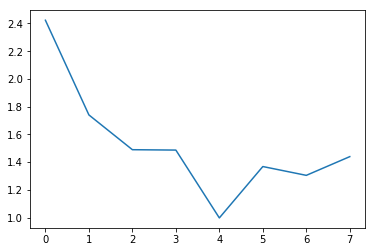

Epoch [2/10], Step [3/6], Loss: 1.3609, Accuracy: 59.38%


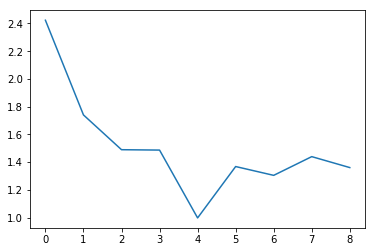

Epoch [2/10], Step [4/6], Loss: 0.9527, Accuracy: 65.62%


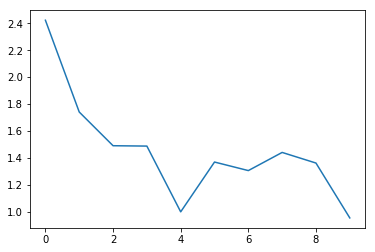

Epoch [2/10], Step [5/6], Loss: 1.1430, Accuracy: 57.81%


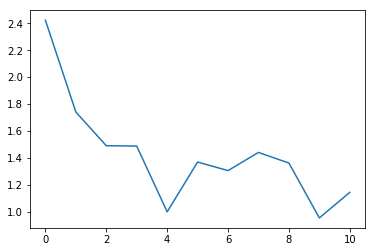

Epoch [2/10], Step [6/6], Loss: 1.2339, Accuracy: 65.38%


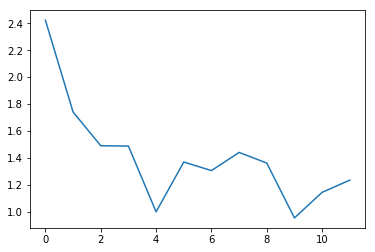

Epoch [3/10], Step [2/6], Loss: 1.2903, Accuracy: 53.12%


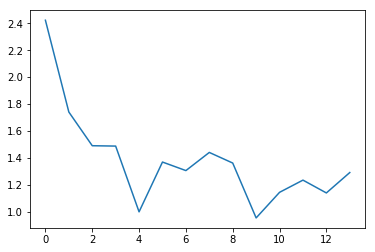

Epoch [3/10], Step [3/6], Loss: 1.2128, Accuracy: 48.44%


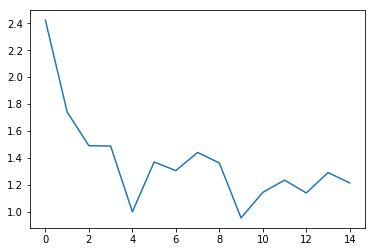

Epoch [3/10], Step [4/6], Loss: 1.1565, Accuracy: 56.25%


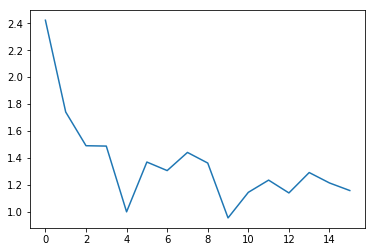

Epoch [3/10], Step [5/6], Loss: 1.2217, Accuracy: 64.06%


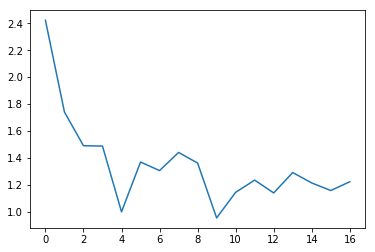

Epoch [3/10], Step [6/6], Loss: 0.9815, Accuracy: 80.77%


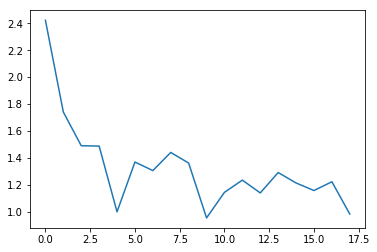

Epoch [4/10], Step [2/6], Loss: 1.2364, Accuracy: 56.25%


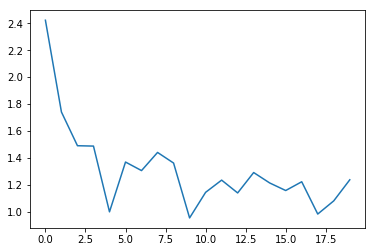

KeyboardInterrupt: 

In [9]:
import torch
import matplotlib.pyplot as plt
model = MySimpleConvNet()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.5)
total_step = len(train_loader)
loss_list = []
acc_list = []
num_epochs = 10

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Прямой запуск
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Обратное распространение и оптимизатор
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Отслеживание точности
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 1 == 0 and epoch != 0 and i != 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
            plt.figure()
            plt.plot(list(range(len(loss_list))), loss_list)
            plt.show()


In [ ]:
for i, (images, labels) in enumerate(val_loader):
    outputs = model(images)
    loss = criterion(outputs, labels)
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list.append(correct / total)
    print('Batch №{} Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(i, loss.item(),
                          (correct / total) * 100))

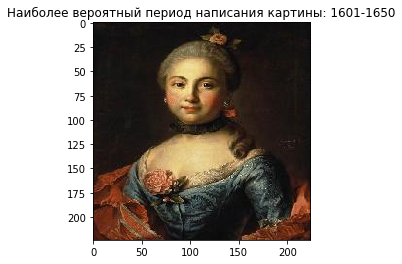

In [17]:
from PIL import Image
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms

from sklearn.linear_model import SGDClassifier
import joblib


random_seed = 4545435
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class StyleMatrix(nn.Module):

    def __init__(self):
        super(StyleMatrix, self).__init__()

    def forward(self, inp):
        G = gram_matrix(inp)
        return G


cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std
    
    
def gram_matrix(inp):
    a, b, c, d = inp.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = inp.view(a * b, c * d).to(device)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)


from numpy import load

mask = load('features8000.npy')
len(mask)


PATH_TO_VGG = "cutted_vgg19.pth"
cnn = models.vgg19(pretrained=False).features.to(device)
cut_vgg19 = torch.nn.Sequential(*(list(cnn.children())[:26])+[StyleMatrix()])

cut_vgg19.load_state_dict(torch.load(PATH_TO_VGG))
cut_vgg19.eval()

cpu = torch.device("cpu")



final_model = joblib.load('sgd.pkl')

target_dict= {
    0: "до 1300",
    1:"1300-1350",
    2:"1351-1400",
    3:"1401-1450",
    4:"1451-1500",
    5:"1501-1550",
    6:"1551-1600",
    7:"1601-1650",
    8:"1651-1700",
    9:"1701-1750",
    10:"1751-1800",
    11:"1801-1850",
    12:"1851-1900",
}

OFFSET = 16



transformations = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def make_prediction(img, device):
    if img.size != (224, 224):
        img = img.resize((224, 244))
    img_tensor = transformations(img)
    G_matrix = cut_vgg19(torch.reshape(img_tensor, (1, 3, 224, 224)).to(device))
    G_vector_numpy = G_matrix.to(cpu).detach().numpy().reshape((1,512*512))[0][mask]
    res = final_model.predict(G_vector_numpy.reshape(1, -1)).item() - OFFSET

    predicted_period = target_dict[res]
    
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title(f"Наиболее вероятный период написания картины: {predicted_period}")
    return res, predicted_period, img


trans = transforms.ToPILImage()

img = Image.open("../resized_images/1751-1800/3211.jpg")

make_prediction(img, device)

                                                        